# CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

## Preparing the Data

In [1]:
from io import open
import glob
import os
import unicodedata
import string

import torch
import random
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import ticker

import time
import math

In [2]:
#alphabet small + capital + ".,;'"
all_letters = string.ascii_letters + ",.;'"
n_letters = len(all_letters)
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;'
56


In [3]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def findFiles(path): return glob.glob(path)
    
    # Read a file and split into lines
    def readLines(filename):
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicodeToAscii(line) for line in lines]
    
    for filename in findFiles('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = readLines(filename)
        category_lines[category] = lines

    return category_lines,all_categories

In [5]:
category_lines, all_categories = load_data()


In [6]:
print(all_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [7]:
print(category_lines['Italian'][:5])


['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

j=letterToTensor('J')
print(j)
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


## Creating the Network

In [9]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [10]:
n_hidden = 128
n_categories = len(all_categories)
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
# one step
input_tensor = letterToTensor('A')
hidden_tensor = rnn.initHidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [12]:
# whole sequence/name
input_tensor = lineToTensor('Albert')
hidden_tensor = rnn.initHidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output)
print(next_hidden.size())

tensor([[-2.9299, -2.8317, -2.8925, -2.8548, -2.9793, -2.9071, -2.7988, -2.8704,
         -2.9150, -2.9074, -2.9612, -2.8678, -2.8174, -2.8727, -2.9290, -2.8821,
         -2.8928, -2.9363]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])


# Training

## Preparing for Training

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 6)


### training example (a name and its language):

In [14]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Alexandropoulos
category = Portuguese / line = Silva
category = Korean / line = San
category = Italian / line = Albricci
category = Polish / line = Czajka
category = Arabic / line = Saliba
category = Vietnamese / line = Quach
category = Vietnamese / line = Doan
category = Polish / line = Szczepanski
category = Greek / line = Kouretas


## Training the Network

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.005

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
-- Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [16]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [17]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [18]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.4840 Kita / Japanese ✓
10000 10% (0m 20s) 2.2049 O'Callaghann / Scottish ✗ (Irish)
15000 15% (0m 29s) 1.3765 Ma / Vietnamese ✓
20000 20% (0m 38s) 0.9314 Hatakeda / Japanese ✓
25000 25% (0m 48s) 0.8065 Thuy / Vietnamese ✓
30000 30% (0m 57s) 2.3878 Ciardha / Spanish ✗ (Irish)
35000 35% (1m 6s) 2.9967 Jordan / Scottish ✗ (Polish)
40000 40% (1m 16s) 2.0968 Szweda / Korean ✗ (Polish)
45000 45% (1m 25s) 2.3908 Delolmo / Italian ✗ (Spanish)
50000 50% (1m 35s) 1.4394 Duncan / Scottish ✓
55000 55% (1m 45s) 0.7172 Mckay / Scottish ✓
60000 60% (1m 55s) 0.6067 Berger / German ✓
65000 65% (2m 4s) 1.0158 Khoury / Arabic ✓
70000 70% (2m 14s) 2.0225 Foong / Vietnamese ✗ (Chinese)
75000 75% (2m 23s) 1.4706 Yim / Korean ✗ (Chinese)
80000 80% (2m 33s) 1.9937 Cornett / Scottish ✗ (French)
85000 85% (2m 42s) 0.5786 Nolan / Irish ✓
90000 90% (2m 51s) 2.2815 Hautum / Arabic ✗ (Dutch)
95000 95% (3m 1s) 0.8397 Sobol / Polish ✓
100000 100% (3m 10s) 1.1418 Nunes / Portuguese ✓


## Plotting the Results

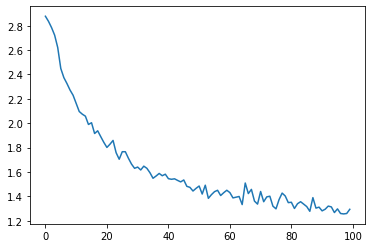

In [20]:
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

## Evaluating the Results

### To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

In [21]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [22]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-23-077bea1f1a1d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-23-077bea1f1a1d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


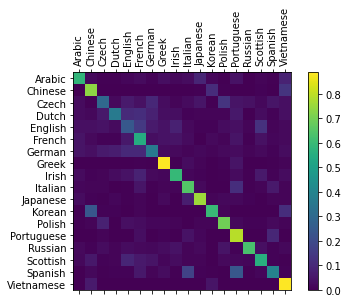

In [23]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## User Input

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [25]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    predict(sentence)


> Kita
(-0.68) Japanese
(-1.59) Czech
(-2.92) Spanish

> Thuy
(-0.09) Vietnamese
(-3.03) Chinese
(-3.50) Korean

> Jordan
(-1.23) English
(-1.94) Czech
(-2.18) Polish

> Berger
(-0.30) German
(-2.07) French
(-3.05) Dutch
